In [1]:
import numpy as np
import numpy.linalg as la
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import animation, rcParams
rcParams.update({'figure.autolayout': True})
%matplotlib inline

In [2]:
sigma_a = 2
sigma_p = 75
dt = 0.01

mu_0 = np.array([-500, 400, 20])
V_0 = np.array([[50**2,0,0],[0,40^2,0], [0,0, 2**2]])
F = np.array([[1,0,0], [dt,1,0], [0,dt,1]])
H = np.array([[1,0,0], [0,0,1]])
Q = np.array([[100*dt,0,0], [0,dt,0], [0,0,dt]])
R = np.array([[sigma_a**2,0], [0,sigma_p**2]])

x = np.loadtxt('x.txt')
n = x.shape[0]

true = np.loadtxt('true.txt')
a_true = true.T[0]
v_true = true.T[1]
p_true = true.T[2]

In [3]:
def kalman_filter(x, mu_0, V_0, R, H, F, Q):
    
    n = x.shape[0]
    
    K = np.zeros(3*2*n).reshape(n,3,2)
    V = np.zeros(3*3*n).reshape(n,3,3)
    P = np.zeros(3*3*n).reshape(n,3,3)
    mu = np.zeros(3*n).reshape(n,3)
    
    #initialize
    K[0] = V_0.dot(H.T).dot(la.inv(H.dot(V_0.dot(H.T)) + R))
    mu[0] = mu_0 + K[0].dot(x[0] - H.dot(mu_0))
    V[0] = (np.eye(3) - K[0].dot(H)).dot(V_0)
    P[0] = F.dot(V[0].dot(F.T)) + Q
    
    for j in np.arange(1,n):
        K[j] = P[j-1].dot(H.T).dot(la.inv(H.dot(P[j-1].dot(H.T)) + R))
        mu[j] = F.dot(mu[j-1]) + K[j].dot(x[j] - H.dot(F.dot(mu[j-1])))
        V[j] = (np.eye(3) - K[j].dot(H)).dot(P[j-1])
        P[j] = F.dot(V[j].dot(F.T)) + Q
    
    return mu, V, P

def kalman_smoother(x, V, mu, F, P):
    
    n = x.shape[0]
    V_hat = np.zeros(3*3*n).reshape(n,3,3)
    C = np.zeros(3*3*n).reshape(n,3,3)
    mu_hat = np.zeros(3*n).reshape(n,3)
    
    # initialize
    mu_hat[n-1] = mu[n-1]
    V_hat[n-1] = V[n-1]
    
    for j in np.arange(n-1)[::-1]:
        C[j] = V[j].dot(F.T).dot(la.inv(P[j]))
        mu_hat[j] = mu[j] + C[j].dot(mu_hat[j+1] - F.dot(mu[j]))
        V_hat[j] = V[j] + C[j].dot(V_hat[j+1] - P[j]).dot(C[j].T)

    return mu_hat, V_hat


In [4]:
mu, V, P = kalman_filter(x, mu_0, V_0, R, H, F, Q)
mu_hat, V_hat = kalman_smoother(x, V, mu, F, P)

In [6]:
x.shape[0]

1990

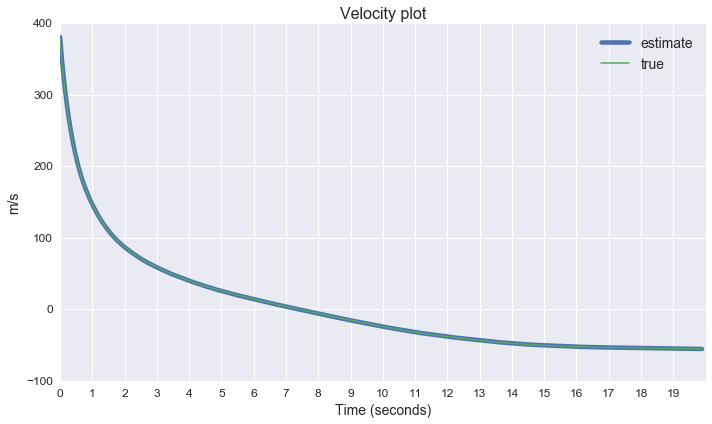

In [27]:
plt.figure(figsize=(10,6)) 
xvals = range(x.shape[0])
plt.plot(xvals,mu_hat.T[1], linewidth=4.5)
plt.plot(xvals,v_true, linewidth=1.5)
plt.title("Velocity plot",size=16)
plt.legend(['estimate','true'],loc='best',fontsize=14)
plt.xticks(np.arange(min(xvals), max(xvals)+1, 100), np.arange(20), size=12)
plt.xlabel("Time (seconds)",size=14)
plt.yticks(size=12)
plt.ylabel("m/s",size=14)
pass

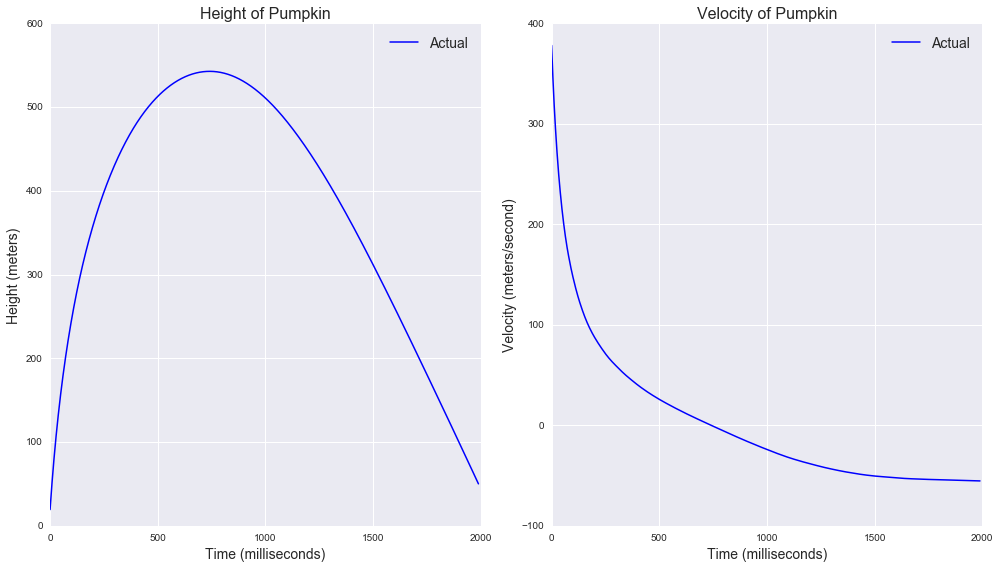

In [39]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14,8))
xvals = np.arange(1990)
axes[0].plot(xvals, p_true, linewidth=1.5, color='blue')  

axes[0].set_title("Height of Pumpkin",size=16)
axes[0].legend(['Actual'],loc='best',fontsize=14)
axes[0].set_xlim([0,2000])
axes[0].set_xlabel("Time (milliseconds)",size=14)
axes[0].set_ylim([0,600])
axes[0].set_ylabel("Height (meters)",size=14)

axes[1].plot(xvals, v_true, linewidth=1.5, color='blue')

axes[1].set_title("Velocity of Pumpkin",size=16)
axes[1].set_xlim([0,2000])
axes[1].set_ylim([-100,400])
axes[1].set_xlabel("Time (milliseconds)",size=14)
axes[1].set_ylabel("Velocity (meters/second)",size=14) 
axes[1].legend(['Actual'],loc='best',fontsize=14)
pass

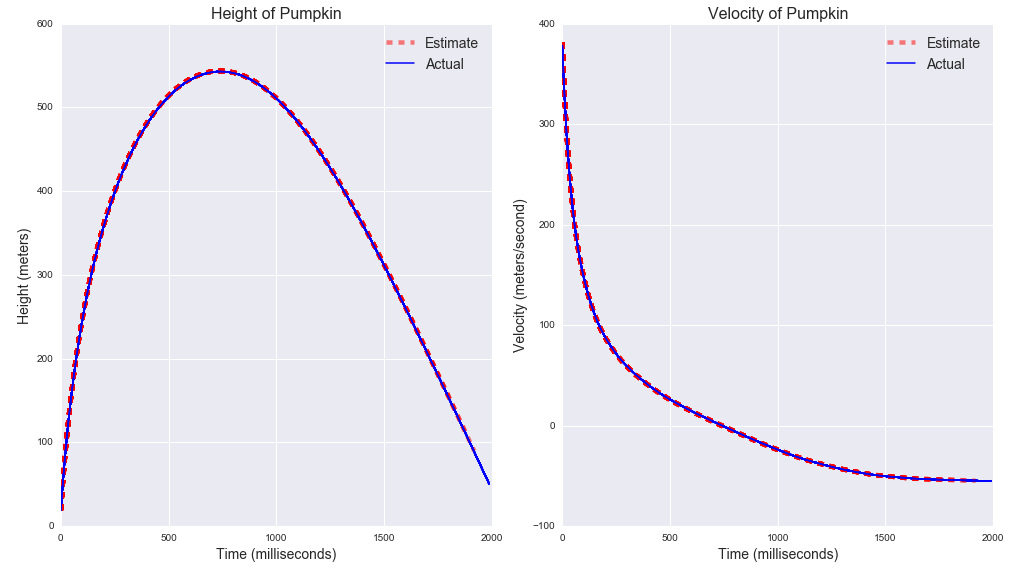

In [38]:
def animate(x):
    
    x = x*40
    xs = np.arange(x)
    y = max(1,x-40)
    ys = np.arange(y)
    
    xvals = np.arange(1990)
    axes[0].plot(ys, mu_hat.T[2][:y], linewidth=4.5, color = 'red', alpha=0.5, linestyle='--')
    axes[0].plot(xvals, p_true, linewidth=1.5, color='blue')  
    
    axes[0].set_title("Height of Pumpkin",size=16)
    axes[0].legend(['Estimate','Actual'],loc='best',fontsize=14)
    axes[0].set_xlim([0,2000])
    axes[0].set_xlabel("Time (milliseconds)",size=14)
    axes[0].set_ylim([0,600])
    axes[0].set_ylabel("Height (meters)",size=14)
#     axes.set_xticks(np.arange(0, 2000+1, 200), 2*np.arange(10), size=12)
        
    axes[1].plot(ys, mu_hat.T[1][:y], linewidth=4.5, color = 'red', alpha=0.5, linestyle='--')
    axes[1].plot(xvals, v_true, linewidth=1.5, color='blue')
    
    axes[1].set_title("Velocity of Pumpkin",size=16)
    axes[1].set_xlim([0,2000])
    axes[1].set_ylim([-100,400])
    axes[1].set_xlabel("Time (milliseconds)",size=14)
    axes[1].set_ylabel("Velocity (meters/second)",size=14) 
    axes[1].legend(['Estimate','Actual'],loc='best',fontsize=14)
      
    
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14,8))
anim = animation.FuncAnimation(fig, animate, frames=50, interval=5, blit=False)
anim.save('KF.gif', writer='imagemagick', fps=10)
plt.show()